In [20]:
# Loading in the Libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import gamma
from matplotlib.colors import LinearSegmentedColormap

# Allows for the hot reloading of modules
%load_ext autoreload
%autoreload 2

# Enable interactive plotting
%matplotlib widget


# Loading in the Simulation Objects
from src.Centrifugation import *
from src.DataLoader import *


color_list = ['#4a678c', '#517193', '#577c9b', '#5d87a2', '#6292aa', '#679eb1', '#ffd6ba', '#f7af95', '#e98975', '#d56459', '#bc3e47', '#9d0a5b']
plot_basepath =  '/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Plots/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## PLAL at various powers

The aim of this experiment is to complete PLAL experiments at various powers, then UV-Vis spec the specturm to analyise how the particle distributions change. Additionally it will be tested how the centrifugation of the SiNPs in a colloids will affected the size distributions. The centrifugation is not the main aim of the experiment but is a secondard effect as it is something that can be tested with a more focused experiment.

There was 2 experimanetal runs to collect samples.

1. Inital test - Daniel Smith
    - `200mW, 800mW` with `1030 nm` wavelngth light and using a `0.14 NA`, and `200 fs` pulse width
    
    This run was done to guage what powered and duraiton would be required to produce apporptiate samples.

2. Primary collection - Haoran Mu
    - `200mW, 600mW, 1W, 1.4W, 1.8W` with `1030 nm` wavelngth light and using a`0.14 NA`, and `200 fs`pulse width


### Loading and Cleaning the data

When initally loading the data from the UV-Vis spectrum, an offset in the data can be obsevred around the 300nm wavelength. This can be adjusted for to show the raw spectrum data from the UV-Vis

In [89]:
# Where the data is stored on device - in excel sheet
spectrum_path = "/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Raw Spectrum Data/SiNP Samples - 20240821.xlsx"

# Loading the raw data -> un processes
data = load_data_from_excel(spectrum_path)

# Re-ordering the columns
order = [
    'Wavelength (nm)', '200mW - 20-08 - Raw', '200mW - 20-08 - 14Ks',
    '800mW - 20-08 - Raw', '800mW - 20-08 - 10Kp', '800mW - 20-08 - 14Kp',
    '200mW - 21-08 - Raw', '200mW - 21-08 - 10Kp', '200mW - 21-08 - 14Ks',
    '600mW - 21-08 - Raw', '600mW - 21-08 - 10Kp ', '600mW - 21-08 - 14Kp', '600mW - 21-08 - 14Ks',
    '1W - 21-08 - Raw', '1W - 21-08 - 10Kp', '1W - 21-08 - 14Ks',
    '1.4W - 21-08 - Raw', '1.4W - 21-08 - 10Kp', '1.4W - 21-08 - 14Kp', '1.4W - 21-08 - 14Ks',
    '1.8W - 21-08 - Raw', '1.8W - 21-08 - 10Kp', '1.8W - 21-08 - 14Kp', '1.8W - 21-08 - 14Ks'
]

# Reorder DataFrame columns based on the correct order
data = data[order]

# Applying a method to remove the offset from the data. 
# This is a dynamic process and is specifc to each series as the offset is not consiatant between each point.
data_corrected = remove_offset(data.copy())

Text(0.5, 0.98, 'Absportion Spectra of SiNPs')

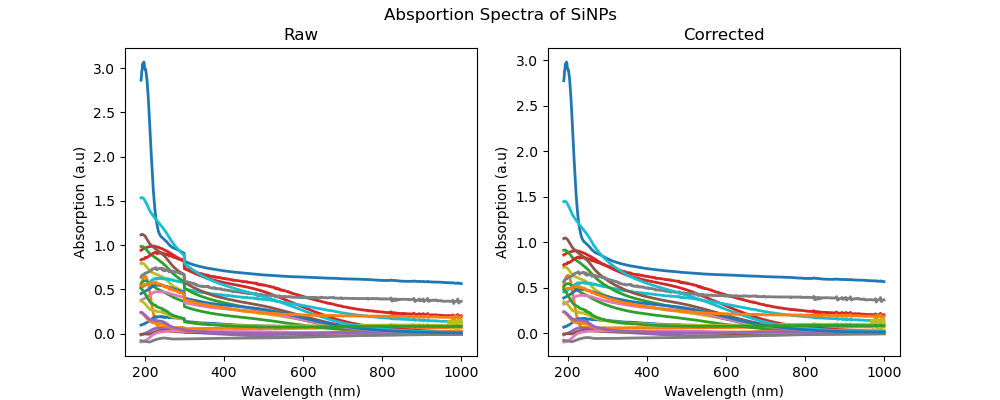

In [90]:
# Plotting the data pre-processes and corrected to show how the data can be cleaned up
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

data_list = [data, data_corrected]

for data_version, index in zip(data_list, range(2)):
    # Set 'Wavelength (nm)' as the x-axis
    x = data_version['Wavelength (nm)'] 

    y_columns = data_version.columns[1:]  # Assuming first column is 'Wavelength (nm)'

    for y_col in y_columns:
        plot_raw_and_avg(ax[index], x, data_version[y_col], y_col, legend=False)


ax[0].set_title('Raw')
ax[1].set_title('Corrected')

ax[0].set_ylabel("Absorption (a.u)")
ax[1].set_ylabel("Absorption (a.u)")

ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

fig.suptitle("Absportion Spectra of SiNPs")

---

### Normalizing the Data: Which Method to Use?

Normalization is a process that transforms data to a common scale without distorting the differences in the ranges of values. Depending on the context and specific requirements, there are different normalization techniques available. Here, we focus on two common types:

1. **Min-Max Normalization (or Feature Scaling) : `min-max` - default**

   Min-Max Normalization scales the data so that the values are within a specific range, typically [0, 1]. This is done by subtracting the minimum value of the data and dividing by the range (maximum - minimum).

   
   $$\text{normalized\_value} = \frac{x - \min(x)}{\max(x) - \min(x)}$$

   - **Purpose**: To rescale the data to a fixed range [0, 1]. The minimum value of the data becomes 0, and the maximum value becomes 1, with all other values proportionally scaled between 0 and 1.
   - **Effect**: This method ensures that both the minimum and maximum values are set to 0 and 1, respectively, while preserving the relative distances between the data points. However, it is sensitive to outliers, which can skew the normalization.

2. **L1 Normalization (or Sum Normalization) : `L1`**

   L1 Normalization scales the data so that the sum of the absolute values equals 1. This technique is useful when the relative proportions between values are more important than their absolute magnitudes.

   
   $$\text{normalized\_value} = \frac{x}{\sum |x|}$$
   

   - **Purpose**: To scale the data such that the total sum of all normalized values is 1.
   - **Effect**: In this case, each value is transformed in such a way that the sum of the absolute values of the normalized data will be 1. This method is particularly useful in scenarios where proportionality is more important than the actual value magnitudes.

3. **Max Normalization : `max`**

   Max Normalization scales the data relative to its maximum value. This ensures that the maximum value becomes 1, while all other values are scaled proportionally to this maximum value.

   
   $$x' = \frac{x}{\max(x)}$$
   

   - **Purpose**: To scale the data so that the maximum value is 1. Other values are scaled proportionally, retaining their original differences relative to the maximum.
   - **Effect**: The resulting range of the data is [0, 1] if all values are positive. If negative values exist, the range can be from `min(x) / max(x)` to 1. This method does not necessarily adjust the minimum value to 0 unless the data naturally starts at zero.

### Key Differences Between Normalization Techniques

1. **Range**:
   - **Min-Max Normalization**: Scales the data to the range [0, 1].
   - **Max Normalization**: Scales the data relative to the maximum value, so the range is [0, 1] if all data points are positive. Otherwise, the range could be from `min(x) / max(x)` to 1.

2. **Data Distribution**:
   - **Min-Max Normalization**: Adjusts both the minimum and maximum values to 0 and 1, respectively, with all other values spread linearly between them. This method is sensitive to outliers since it is based on the extreme values in the dataset.
   - **Max Normalization**: Only adjusts the maximum value to 1, scaling all other values proportionally. This retains the relative distribution and distances between data points without shifting the entire data set.

3. **Use Cases**:
   - **Min-Max Normalization**: Commonly used in machine learning preprocessing to ensure all features are on the same scale, particularly for algorithms that are sensitive to the scale of input data, such as neural networks and k-nearest neighbors.
   - **Max Normalization**: Useful when you want to normalize data relative to a significant maximum value, or when you want to maintain the relative proportions of the dataset based on the maximum value.

Normalised data using all mode.


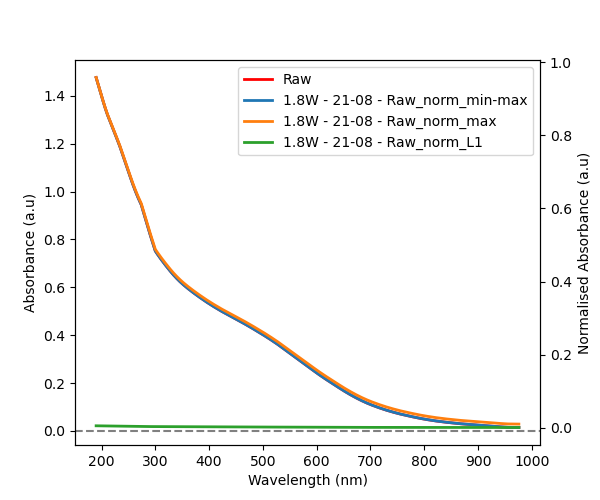

In [11]:
# Filtering for just a single data series to see how the different normalisation techniques affect the spectrums
selected_data = data_corrected[['Wavelength (nm)', '1.8W - 21-08 - Raw']].copy()

# Running the normalisation techniques
selected_data = normalize_data(selected_data, exclude=['Wavelength (nm)'], mode='all')

fig, ax = plt.subplots(1, figsize=(6, 5), sharex=True, sharey=True)

x = selected_data['Wavelength (nm)']

plot_raw_and_avg(ax, x, selected_data['1.8W - 21-08 - Raw'], key='Raw', avg_step=25, legend=False, color='red')

ax.axhline(y=0, linestyle='--', color='grey')

ax1 = ax.twinx()
y_columns = selected_data.columns[2:] 
for y_col in y_columns:
    plot_raw_and_avg(ax1, x, selected_data[y_col], y_col, avg_step=25, legend=False)
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u)')
ax1.set_ylabel('Normalised Absorbance (a.u)')

# Combineing both legends
# Get handles and labels from both axes
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()

# Combine handles and labels
handles = handles_ax + handles_ax1
labels = labels_ax + labels_ax1

# Create a combined legend on the primary axis
ax.legend(handles, labels, loc='upper right')

### Saving the normalised data for later use

In [25]:
# data = normalize_data(data_corrected, ['Wavelength (nm)'], mode='min-max')
data_filtered = data[data['Wavelength (nm)'] <= 900]

# Total into parquet filed --> faster loading
# save_dataframe(data, '/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Raw Spectrum Data/SiNP Samples - corrected full spectrum - 20240821.parquet')


# Seperate Spectrums
basepath = "/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Raw Spectrum Data/seperate_spectrums/"
bulk_dump_columns(data_filtered, basepath)

Saved 46 files


---
## Loading the data -- Start Here when returning

In [2]:
data = load_dataframe('/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Raw Spectrum Data/SiNP Samples - corrected full spectrum - 20240821.parquet')
data

DataFrame successfully loaded from /Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Raw Spectrum Data/SiNP Samples - corrected full spectrum - 20240821.parquet


Wavelength (nm)  200mW - 20-08 - Raw  200mW - 20-08 - 14Ks  \
0               1000             0.566998              0.067128   
1                999             0.567969              0.067054   
2                998             0.568166              0.067060   
3                997             0.568259              0.067279   
4                996             0.569006              0.067254   
..               ...                  ...                   ...   
806              194             2.959137              0.591667   
807              193             2.898910              0.579642   
808              192             2.879760              0.565108   
809              191             2.810736              0.545759   
810              190             2.777224              0.518549   

     800mW - 20-08 - Raw  800mW - 20-08 - 10Kp  800mW - 20-08 - 14Kp  \
0               0.003600              0.021185             -0.006824   
1               0.003748              0.021519             -0.006630   
2               0.003639              0.021387             -0.006571   
3               0.003729              0.021603             -0.006732   
4               0.003679              0.021495             -0.006925   
..                   ...                   ...                   ...   
806             0.531483              0.871829             -0.011255   
807             0.528094              0.869470             -0.012076   
808             0.523061              0.867141             -0.013747   
809             0.517689              0.864088             -0.015360   
810             0.509366              0.859823             -0.018055   

     200mW - 21-08 - Raw  200mW - 21-08 - 10Kp  200mW - 21-08 - 14Ks  \
0              -0.004918             -0.003717             -0.007372   
1              -0.004797             -0.003531             -0.007332   
2              -0.004781             -0.003190             -0.007274   
3              -0.004939             -0.003478             -0.007042   
4              -0.005104             -0.003373             -0.007289   
..                   ...                   ...                   ...   
806            -0.006256             -0.095776             -0.082356   
807            -0.006879             -0.096422             -0.081248   
808            -0.007350             -0.096890             -0.080819   
809            -0.007865             -0.097134             -0.079864   
810            -0.009092             -0.097382             -0.078477   

     600mW - 21-08 - Raw  ...  1W - 21-08 - 10Kp_norm  1W - 21-08 - 14Ks_norm  \
0               0.009748  ...                0.022200                0.077359   
1               0.010022  ...                0.020680                0.076813   
2               0.010092  ...                0.020285                0.076509   
3               0.010155  ...                0.019164                0.077650   
4               0.010139  ...                0.018247                0.077857   
..                   ...  ...                     ...                     ...   
806             0.727335  ...                0.876341                0.974649   
807             0.728845  ...                0.875804                0.994458   
808             0.728819  ...                0.875859                0.999279   
809             0.728086  ...                0.872993                1.000000   
810             0.724732  ...                0.865785                0.999755   

     1.4W - 21-08 - Raw_norm  1.4W - 21-08 - 10Kp_norm  \
0                   0.000285                  0.000000   
1                   0.000399                  0.000325   
2                   0.000492                  0.000372   
3                   0.000534                  0.000815   
4                   0.000540                  0.000594   
..                       ...                       ...   
806                 0.999083                  0.783956   
807                 1.000000     

---
## How does the different powers affect the Raw Spectrums?

Text(0.5, 0.98, 'Raw Spectrums')

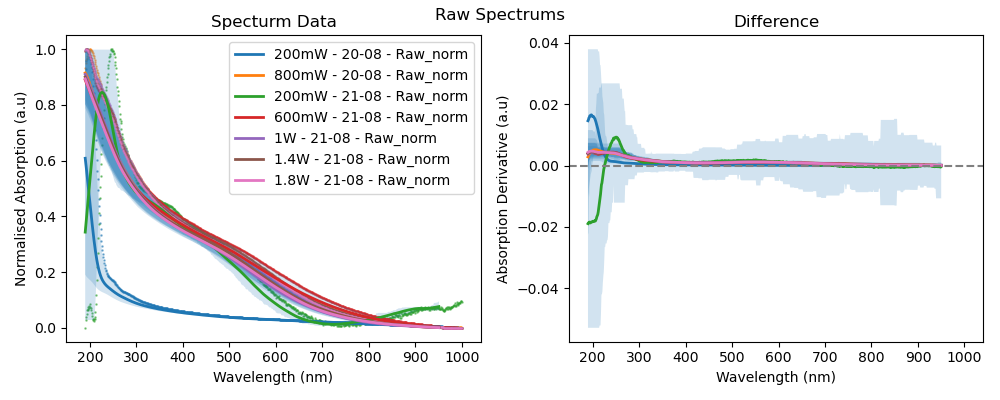

In [3]:
raw_data = data.copy()
y_columns = [col for col in raw_data.columns if 'w_norm' in col.lower()]

avg_window = 50

x = raw_data['Wavelength (nm)']

# Plot each y-column against the x-axis
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for y_col in y_columns:
    plot_raw_and_avg(ax[0], x, raw_data[y_col], y_col, avg_step = avg_window, scatter = True, IQR = True)
    plot_raw_and_avg(ax[1], x, raw_data[y_col].diff(), y_col, legend=False, avg_step = avg_window, IQR=True, scatter=False)

ax[1].axhline(y=0, color='grey', linestyle = '--')

ax[0].set_title("Specturm Data")
ax[1].set_title("Difference")

ax[0].set_ylabel("Normalised Absorption (a.u)")
ax[1].set_ylabel("Absorption Derivative (a.u)")

ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

fig.tight_layout()
fig.suptitle('Raw Spectrums')

# path = plot_basepath + 'Raw Spectrums' + '.png'
# fig.savefig(path, dpi=300)


## How does each series look??

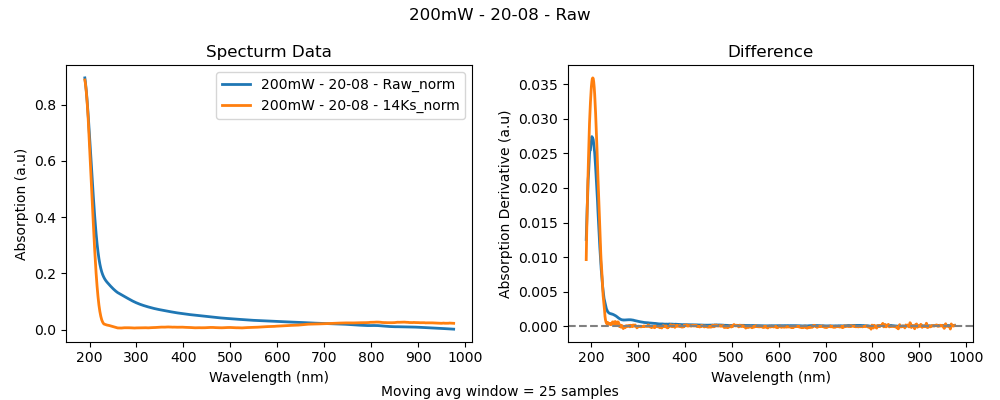

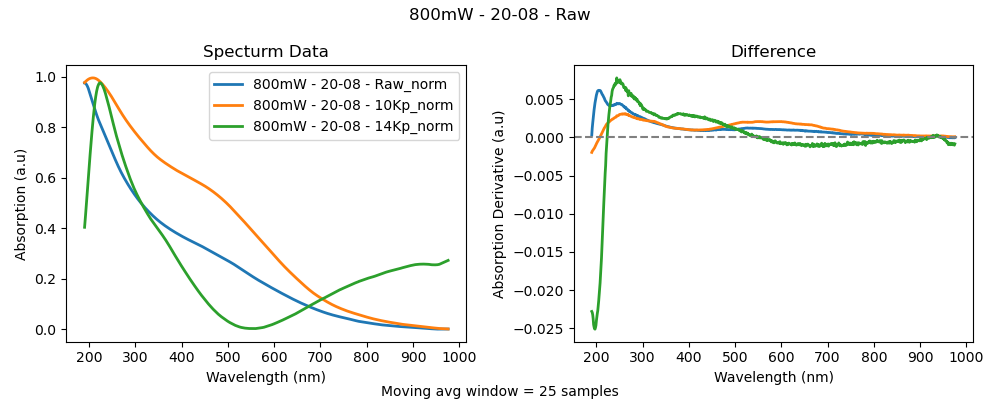

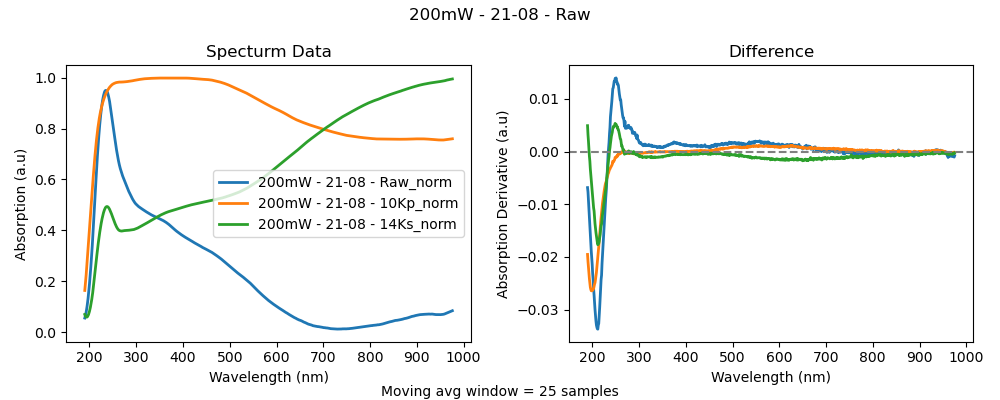

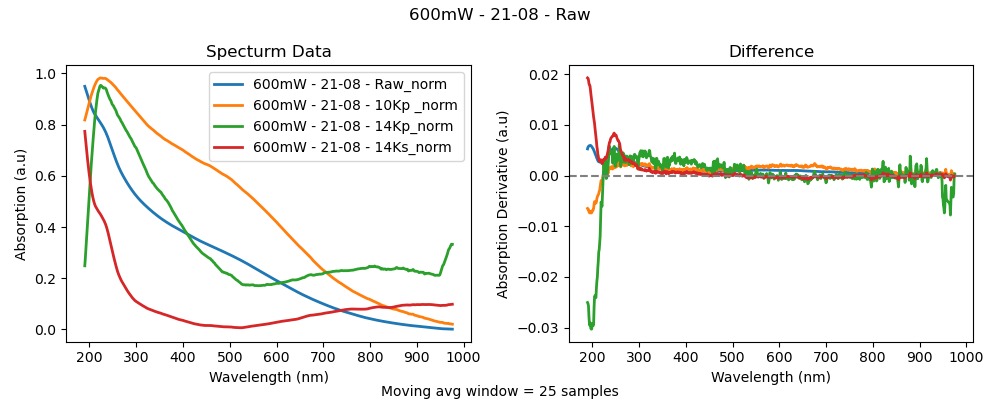

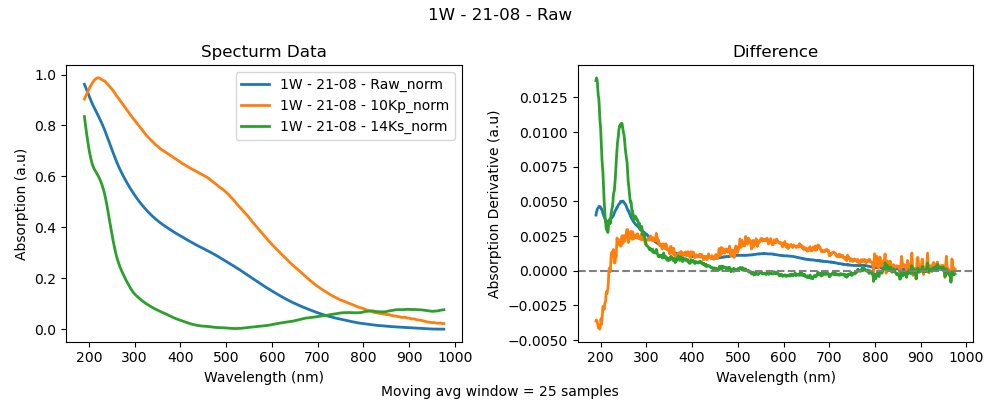

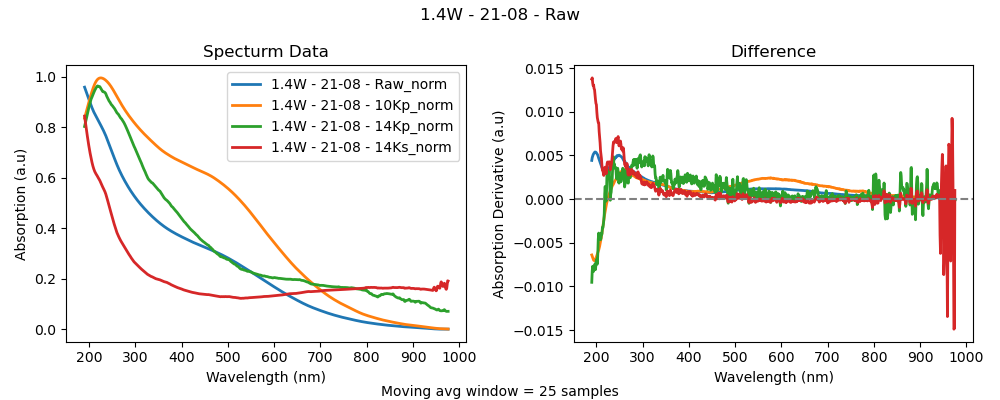

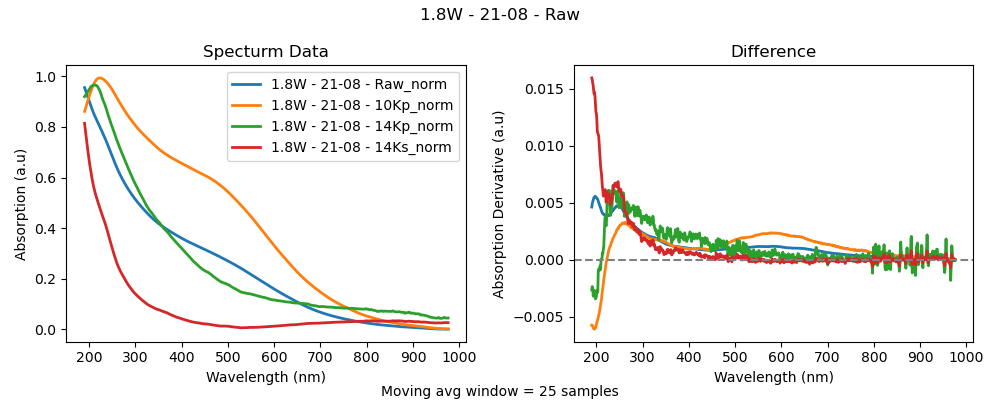

In [17]:
column_groups = group_columns(data.columns)
x = data['Wavelength (nm)']

avg_window = 25

basepath = '/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Raw Spectrum Data/Spectrum Plots/'

for column_group in column_groups:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    fig.suptitle(column_group[1])
    y_columns = [col for col in column_group if 'norm' in col.lower()] # select just the norm fields
    
    for y_col in y_columns:
        
        plot_raw_and_avg(ax[0], x, data[y_col], y_col, avg_step = avg_window, scatter = False, IQR = False)
        plot_raw_and_avg(ax[1], x, data[y_col].diff(), y_col, legend=False, avg_step = avg_window, IQR=False, scatter=False)
        
    ax[1].axhline(y=0, color='grey', linestyle = '--')


    ax[0].set_title("Specturm Data")
    ax[1].set_title("Difference")

    ax[0].set_ylabel("Absorption (a.u)")
    ax[1].set_ylabel("Absorption Derivative (a.u)")

    ax[0].set_xlabel("Wavelength (nm)")
    ax[1].set_xlabel("Wavelength (nm)")

    text = f"Moving avg window = {avg_window} samples"

    # Add text to the bottom of the figure
    fig.text(0.5, 0.01, text, ha='center', fontsize=10)

    fig.tight_layout()

    path = plot_basepath + "uv_vis_spectrums/centrifugation_cycles/" + column_group[1] + '.png'
    fig.savefig(path, dpi=300)

---
## Loading and creating the Df for generated particle distributions


In [42]:
con_path = "/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Concentrations2/"
fitted_spec_path = "/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Fitted Spectrums2/"

# loading the dataframes
# con_df = load_mathematica_outputs(con_path, 'Radii (nm)', col_formatter='_')
# fitted_spec_df = load_mathematica_outputs(fitted_spec_path, 'Wavelength (nm)', col_formatter='_')

# Saving the dataframes
save_dataframe(con_df, con_path + 'Concentrations.parquet')
# save_dataframe(fitted_spec_df, fitted_spec_path + 'fitted_spec.parquet')

Error saving DataFrame: Unsupported cast from dictionary<values=extension<pandas.interval<ArrowIntervalType>>, indices=int8, ordered=1> to struct using function cast_struct
DataFrame successfully saved to /Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Fitted Spectrums2/fitted_spec.parquet


True

In [4]:
# Loading the conctration and fitted spec data
con_path = "/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Concentrations2/Concentrations.parquet"
fitted_spec_path = "/Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Fitted Spectrums2/fitted_spec.parquet"

# loading the dataframes
con_df = load_dataframe(con_path)
# con_df = normalize_data(con_df, exclude=['Radii (nm)'])
fitted_spec_df = load_dataframe(fitted_spec_path)

DataFrame successfully loaded from /Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Concentrations2/Concentrations.parquet
DataFrame successfully loaded from /Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Fitted Spectrums2/fitted_spec.parquet


### Fitted spectrum VS measured UV-Vis spectrums

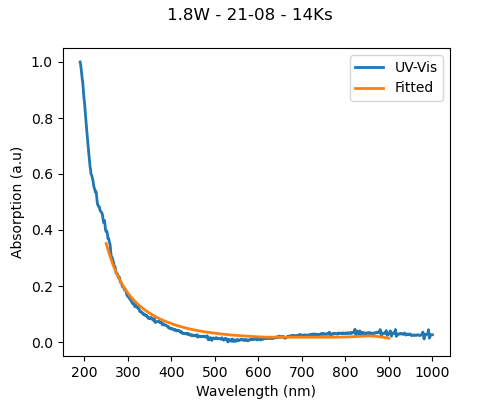

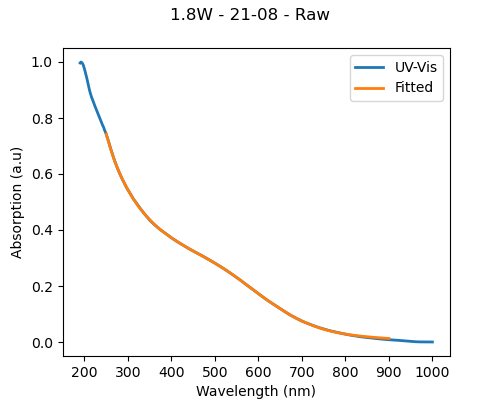

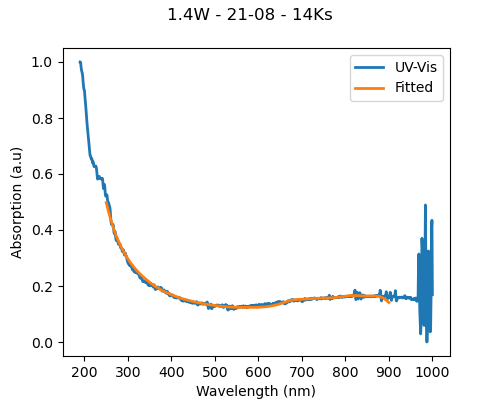

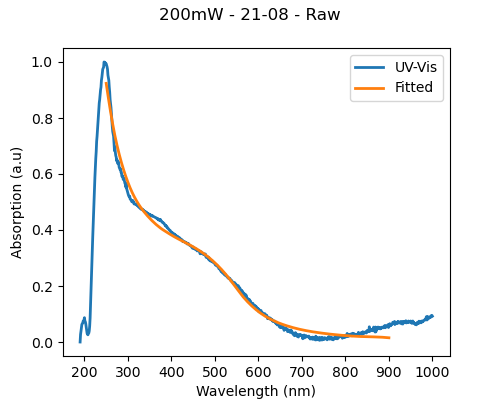

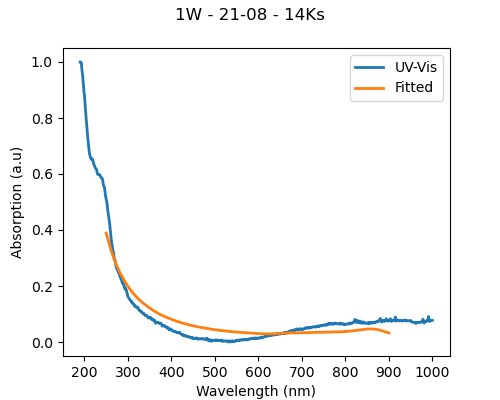

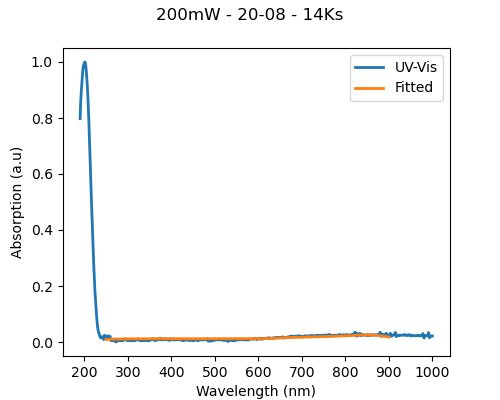

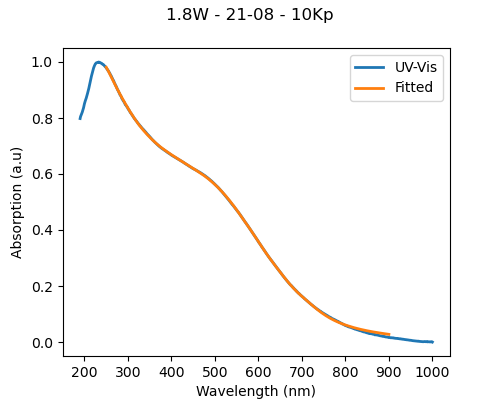

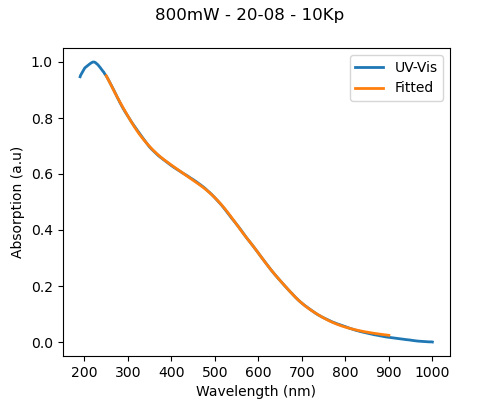

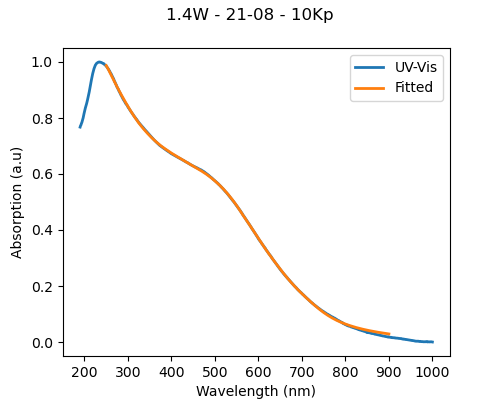

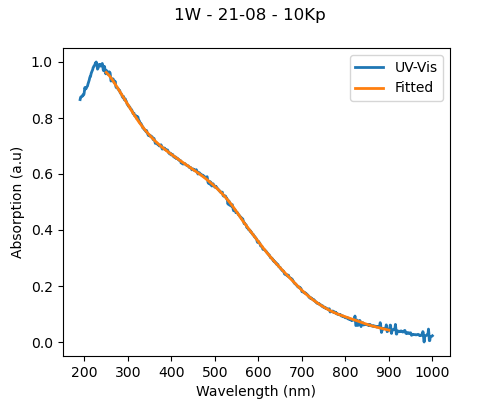

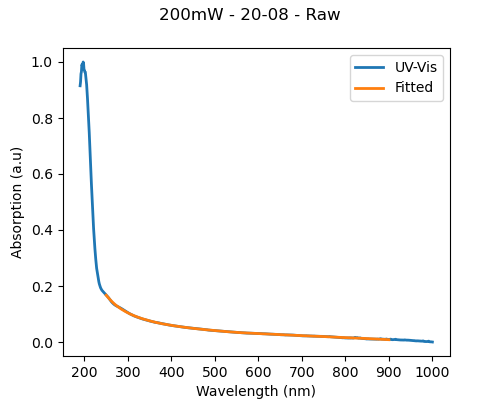

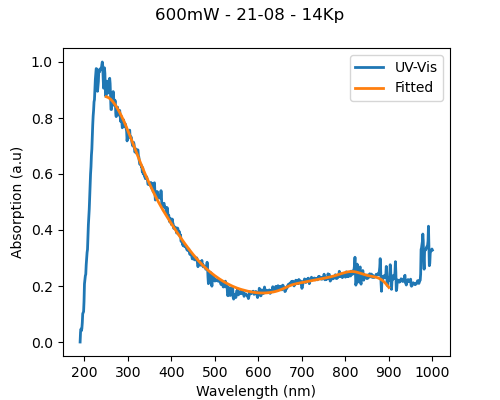

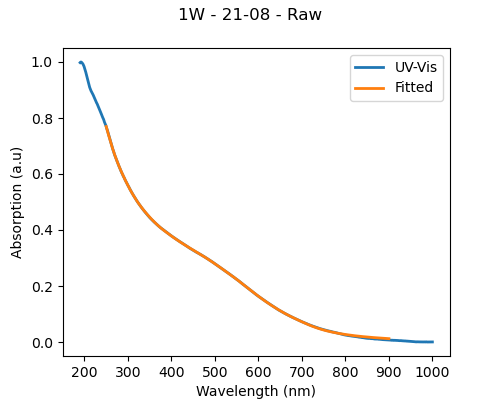

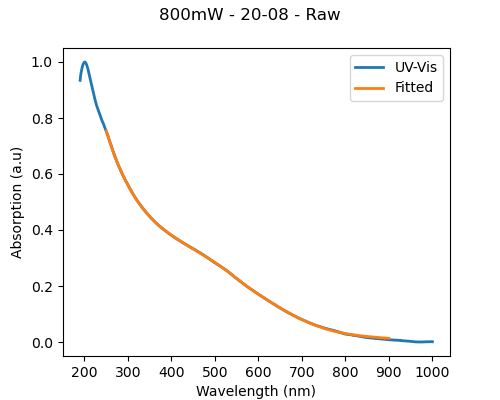

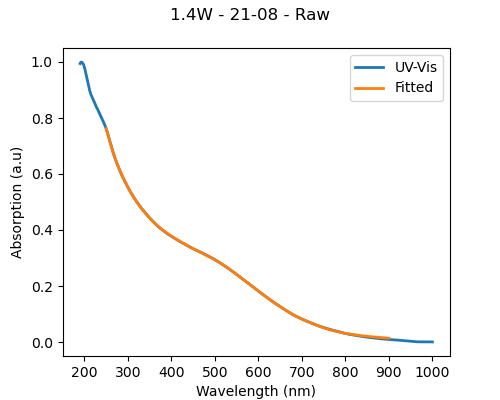

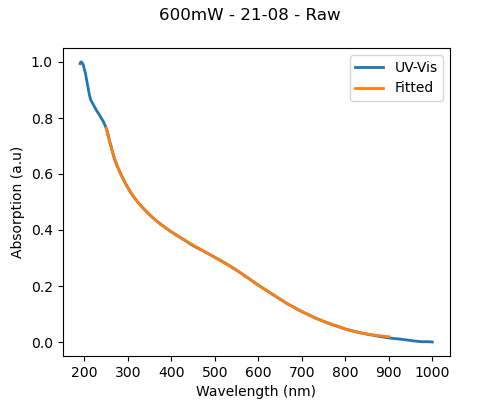

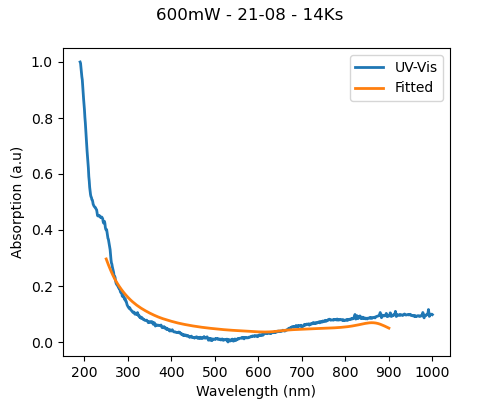

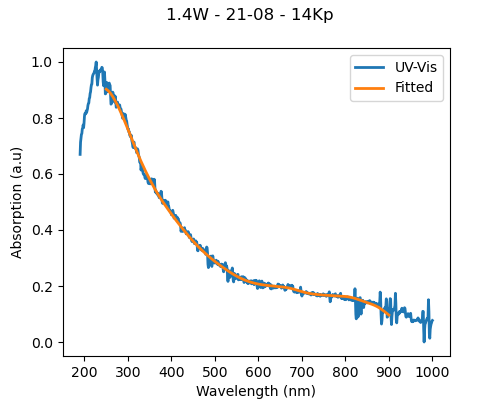

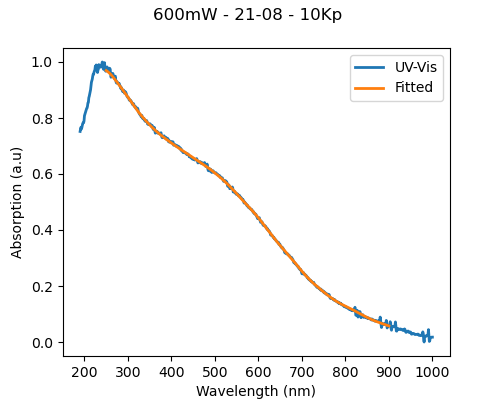

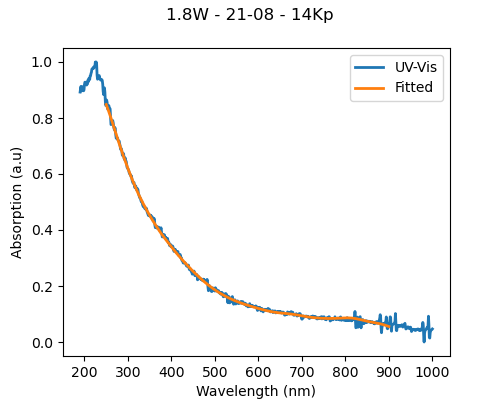

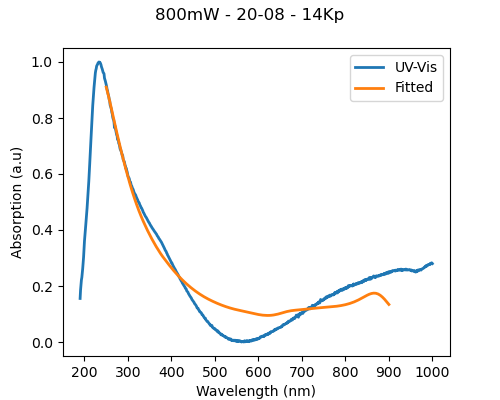

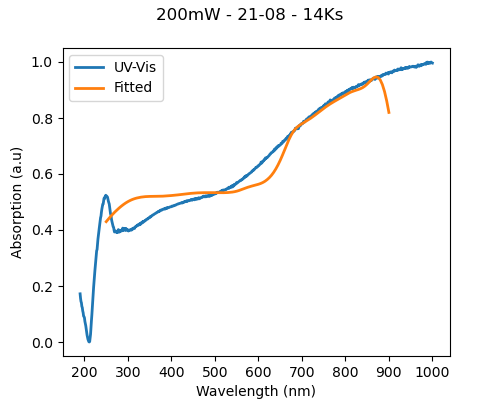

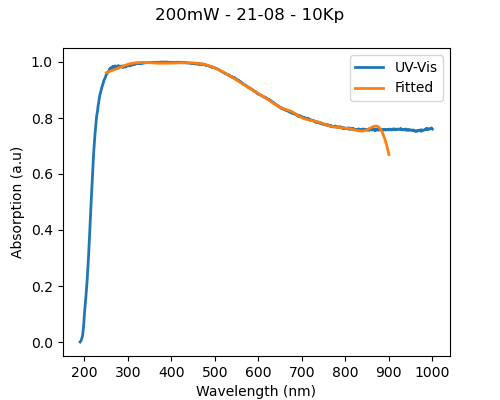

In [16]:
y_columns = fitted_spec_df.columns[1:]  # Assuming first column is 'Wavelength (nm)'

for y_col in y_columns:

    fig, ax = plt.subplots(1, figsize=(5,4)) # Set the figure size
    fig.suptitle(y_col)
    ax.plot(data['Wavelength (nm)'], data[y_col + '_norm'], label='UV-Vis', linewidth=2)
    ax.plot(fitted_spec_df['Wavelength (nm)'], fitted_spec_df[y_col], label='Fitted', linewidth=2)

    ax.set_ylabel("Absorption (a.u)")
    ax.set_xlabel("Wavelength (nm)")

    ax.legend()
    name = y_col.replace('.', '-')
    path = plot_basepath + "fittted_spectrums/"  + name + '.png'
    
    fig.savefig(path, dpi=300)


Text(0.5, 0.98, 'Concentration over Powers')

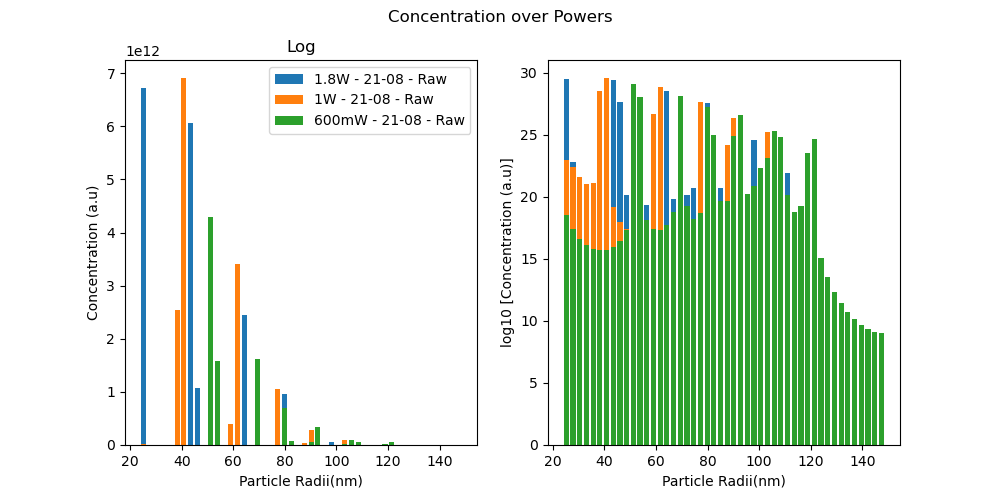

In [6]:
mask = con_df['Radii (nm)'] >= 25

x = con_df['Radii (nm)'][mask]
# y_columns = [col for col in con_df.columns if '21-08 - raw' in col.lower()]
# y_columns = ['200mW - 21-08 - Raw', '600mW - 21-08 - Raw', '1W - 21-08 - Raw', '1.4W - 21-08 - Raw', '1.8W - 21-08 - Raw']
y_columns = ['1.8W - 21-08 - Raw', '1W - 21-08 - Raw','600mW - 21-08 - Raw']
bar_width = 2

fig, ax = plt.subplots(1, 2, figsize=(10,5)) # Set the figure size

for y_col, index in zip(y_columns, range(len(y_columns))):
    # plot_raw_and_avg(ax, x, (con_df[y_col][mask]), key=y_col, avg_step=1, scatter=True)
    ax[0].bar(x, (con_df[y_col][mask]), label=y_col, width=2)
    ax[1].bar(x, np.log(con_df[y_col][mask]), width=2)


ax[0].legend()
ax[0].set_ylabel("Concentration (a.u)")
ax[1].set_ylabel("log10 [Concentration (a.u)]")
ax[0].set_xlabel("Particle Radii(nm)")
ax[1].set_xlabel("Particle Radii(nm)")

ax[0].set_title("Raw")
ax[0].set_title("Log")

fig.suptitle("Concentration over Powers")


/opt/anaconda3/envs/Particle_Sim/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'Concentration over Powers')

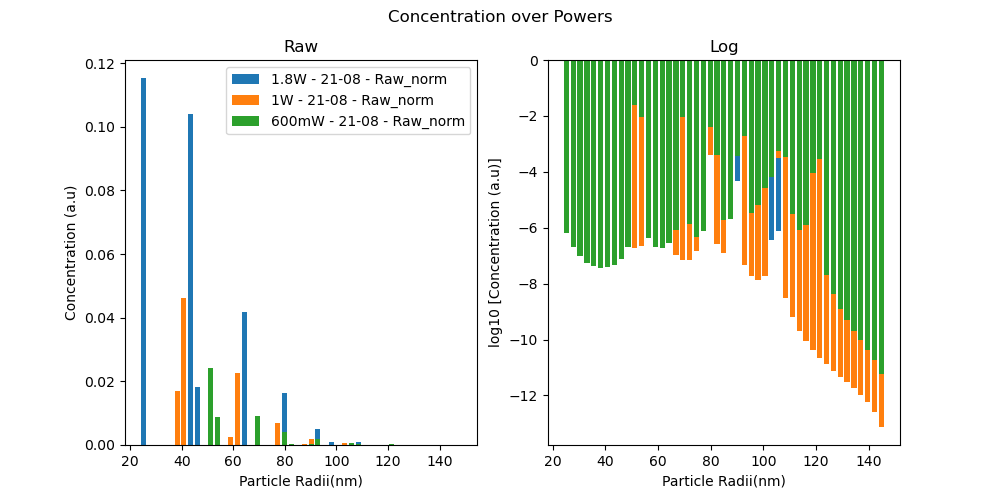

In [36]:
# Same as above but with normalised data
mask = con_df['Radii (nm)'] >= 25

x = con_df['Radii (nm)'][mask]
y_columns = ['1.8W - 21-08 - Raw_norm', '1W - 21-08 - Raw_norm','600mW - 21-08 - Raw_norm']
bar_width = 2

fig, ax = plt.subplots(1, 2, figsize=(10,5)) # Set the figure size

for y_col, index in zip(y_columns, range(len(y_columns))):
    # plot_raw_and_avg(ax, x, (con_df[y_col][mask]), key=y_col, avg_step=1, scatter=True)
    ax[0].bar(x, (con_df[y_col][mask]), label=y_col, width=2)
    ax[1].bar(x, np.log10(con_df[y_col][mask]), width=2)


ax[0].legend()
ax[0].set_ylabel("Concentration (a.u)")
ax[1].set_ylabel("log10 [Concentration (a.u)]")
ax[0].set_xlabel("Particle Radii(nm)")
ax[1].set_xlabel("Particle Radii(nm)")

ax[0].set_title("Raw")
ax[1].set_title("Log")

fig.suptitle("Concentration over Powers")

Can this data be interpulated???? --> no

Text(0.5, 0, 'Particle Radii(nm)')

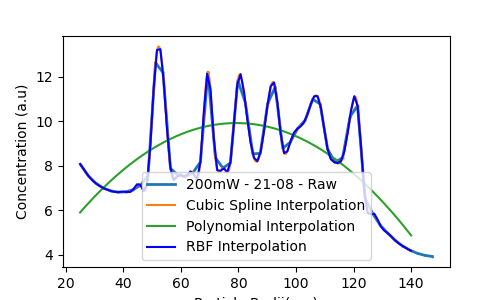

In [46]:
from scipy.interpolate import CubicSpline
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import Rbf



mask = con_df['Radii (nm)'] >= 25

y_columns = ['600mW - 21-08 - Raw']

x = con_df['Radii (nm)'][mask]
y = np.log10(con_df['600mW - 21-08 - Raw'][mask])


fig, ax = plt.subplots(1, figsize=(5,3)) # Set the figure size
plot_raw_and_avg(ax, x, y, key=y_col, avg_step=1, scatter=True)


# Cubespline example
cs = CubicSpline(x, y)  
x_interp = np.linspace(25, 140, 1000)
y_interp = cs(x_interp)
ax.plot(x_interp, y_interp, label='Cubic Spline Interpolation')

# Polynomial Interpolation
# Fit a polynomial of degree 2 (quadratic)
p = Polynomial.fit(x, y, deg=2)

# Interpolation points
x_interp = np.linspace(25, 140, 100)
y_interp = p(x_interp)

ax.plot(x_interp, y_interp, label='Polynomial Interpolation')


# Radial Basis Function Interpolation
rbf = Rbf(x, y, function='multiquadric')
# Interpolation points
x_interp = np.linspace(25, 140, 100)
y_interp = rbf(x_interp)
ax.plot(x_interp, y_interp, color='blue', label='RBF Interpolation')


ax.legend()
ax.set_ylabel("Concentration (a.u)")
ax.set_xlabel("Particle Radii(nm)")




Text(0.5, 0, 'Particle Radii(nm)')

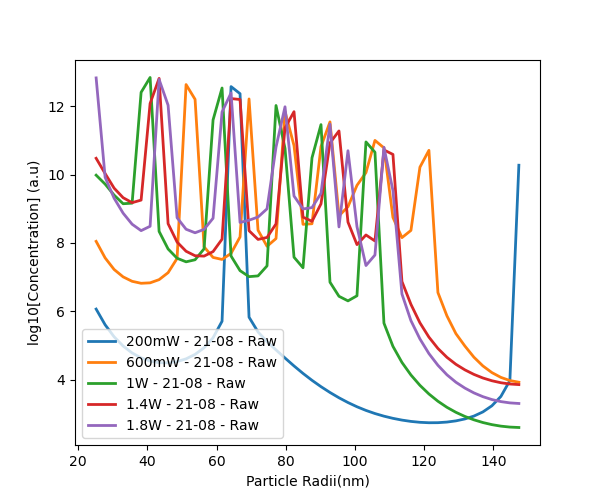

In [47]:
lowe_lim = 25
mask = con_df['Radii (nm)'] >= lowe_lim

x = con_df['Radii (nm)'][mask]
# y_columns = [col for col in con_df.columns if '21-08 - raw' in col.lower()]
y_columns = ['200mW - 21-08 - Raw', '600mW - 21-08 - Raw', '1W - 21-08 - Raw', '1.4W - 21-08 - Raw', '1.8W - 21-08 - Raw']
bar_width = 2

fig, ax = plt.subplots(1, figsize=(6,5)) # Set the figure size

for y_col, index in zip(y_columns, range(len(y_columns))):
    y = np.log10(con_df[y_col][mask])
    cs = CubicSpline(x, y)  
    x_interp = np.linspace(lowe_lim, 140, 10000)
    y_interp = cs(x_interp)
    # ax.plot(x_interp, y_interp, label=y_col)
    # plot_raw_and_avg(ax, x_interp, y_interp, key=y_col, avg_step=25)
    plot_raw_and_avg(ax, x, y, avg_step=1, scatter=False, key=y_col, IQR=True)


ax.legend()
ax.set_ylabel("log10[Concentration] (a.u)")
ax.set_xlabel("Particle Radii(nm)")

--- 
### How to anaylsis the Concentration values?

We need to bin the conerations of the particles as averages, this will make it easer to show the change in concentrairon overtime

[ 20.  40.  60.  80. 100. 120. 140. 160.]


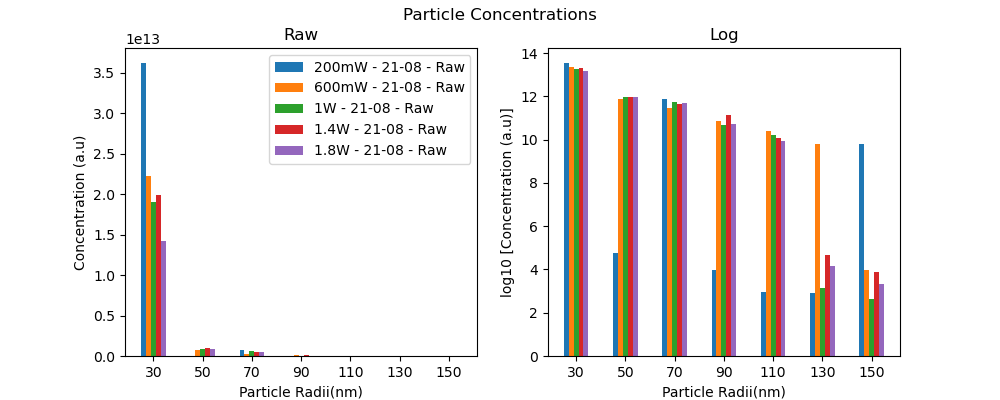

In [40]:
mask = con_df['Radii (nm)'] >= 0
x = con_df['Radii (nm)'][mask]
# y_columns = ['1.8W - 21-08 - Raw', '1W - 21-08 - Raw','600mW - 21-08 - Raw']
y_columns = ['200mW - 21-08 - Raw', '600mW - 21-08 - Raw', '1W - 21-08 - Raw', '1.4W - 21-08 - Raw', '1.8W - 21-08 - Raw']

# y_columns = ['1.8W - 21-08 - Raw_norm', '1W - 21-08 - Raw_norm','600mW - 21-08 - Raw_norm'] # normalised conetration -> not a good statstical analysis

con_df_bin = get_df_bins(con_df, 20)
mask = con_df_bin['Radii (nm)'] >= 0

fig, ax = plt.subplots(1, 2, figsize=(10,4)) # Set the figure size


for y_col, index in zip(y_columns, range(len(y_columns))):
    # plot_histograms(ax, con_df[y_col][mask], label=y_col)
    ax[0].bar(con_df_bin['Radii (nm)'][mask] - 2*(2 - index), (con_df_bin[y_col][mask]), label = y_col, width=2)
    ax[1].bar(con_df_bin['Radii (nm)'][mask] - 2*(2 - index), np.log10(con_df_bin[y_col][mask]), label = y_col, width=2)

    # plt.scatter(con_df_bin['Radii (nm)'][mask]- 3*(1 - index), np.log(con_df_bin[y_col][mask]), alpha=0.8)
    # plt.plot(con_df_bin['Radii (nm)'][mask], np.log(con_df_bin[y_col][mask]), linewidth = 2, alpha=0.8)



ax[0].legend()
ax[0].set_ylabel("Concentration (a.u)")
ax[1].set_ylabel("log10 [Concentration (a.u)]")

ax[0].set_xlabel("Particle Radii(nm)")
ax[1].set_xlabel("Particle Radii(nm)")

ax[0].set_title("Raw")
ax[1].set_title("Log")

ax[0].set_xticks(con_df_bin['Radii (nm)'][mask])
ax[1].set_xticks(con_df_bin['Radii (nm)'][mask])

fig.suptitle('Particle Concentrations')

path = plot_basepath + 'concentrations/Raw Concentrarions - complete' + '.png'
fig.savefig(path, dpi=300)

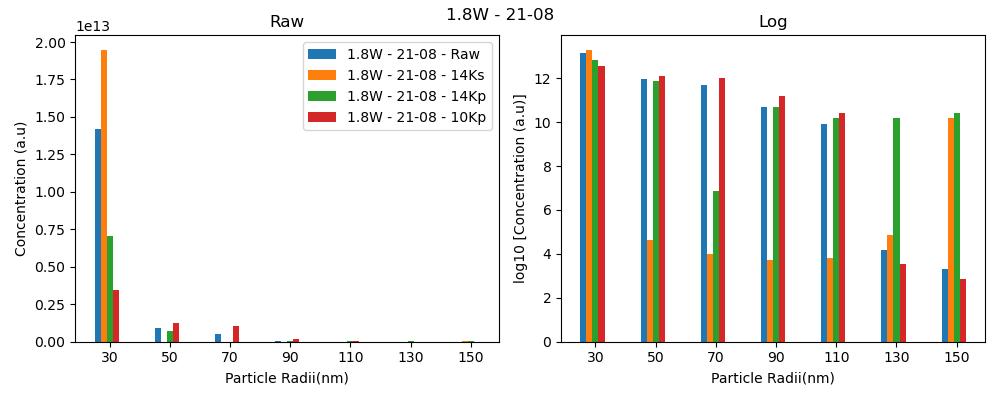

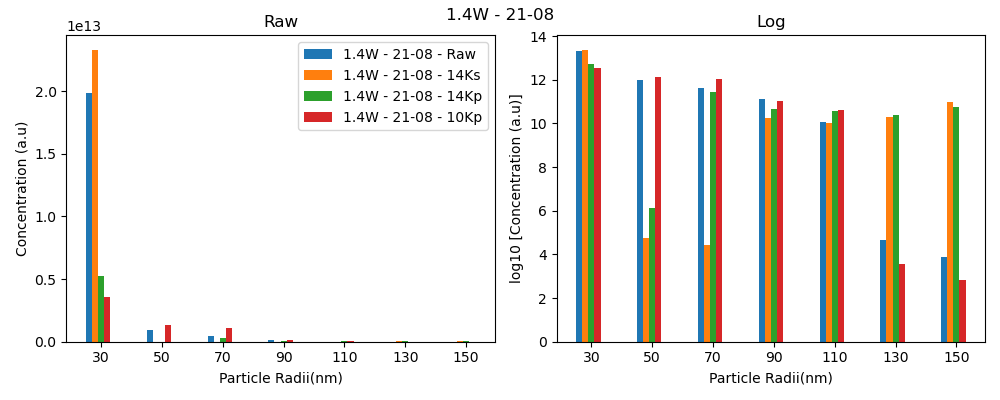

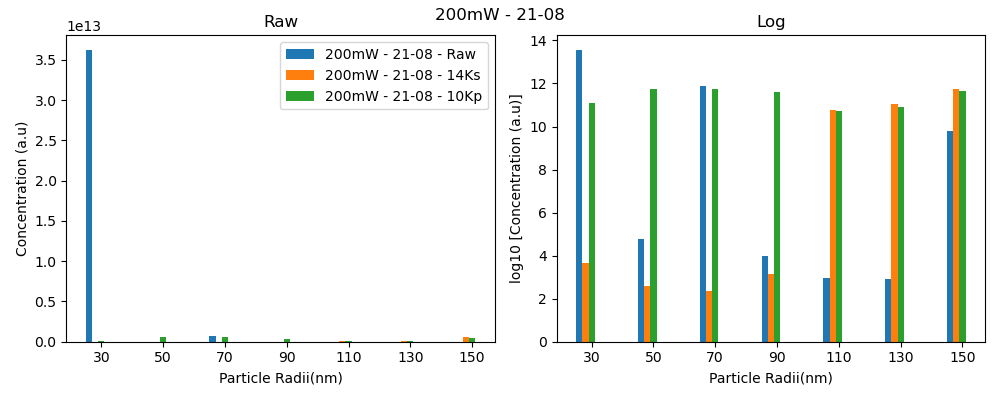

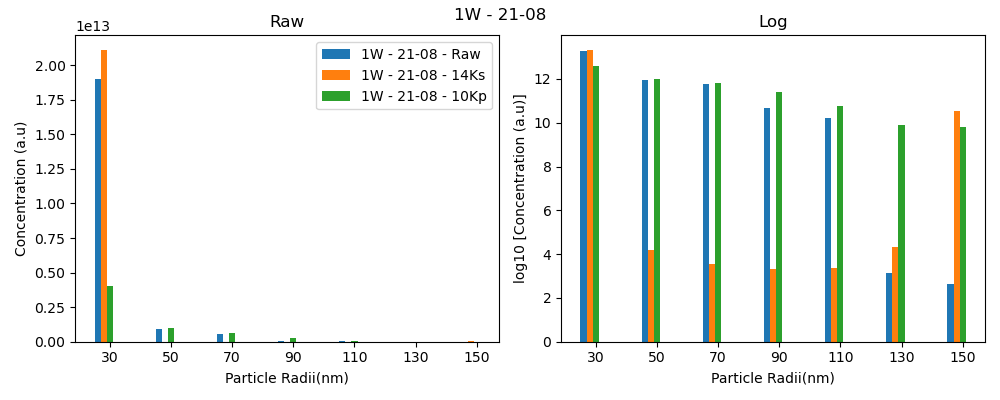

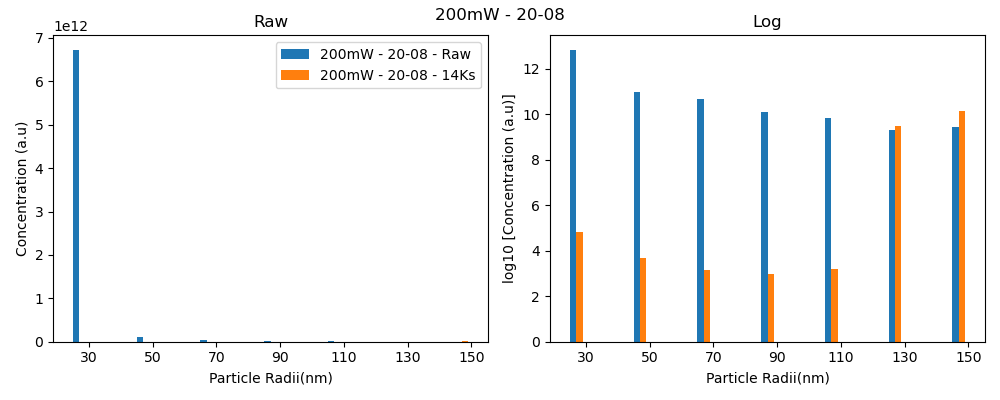

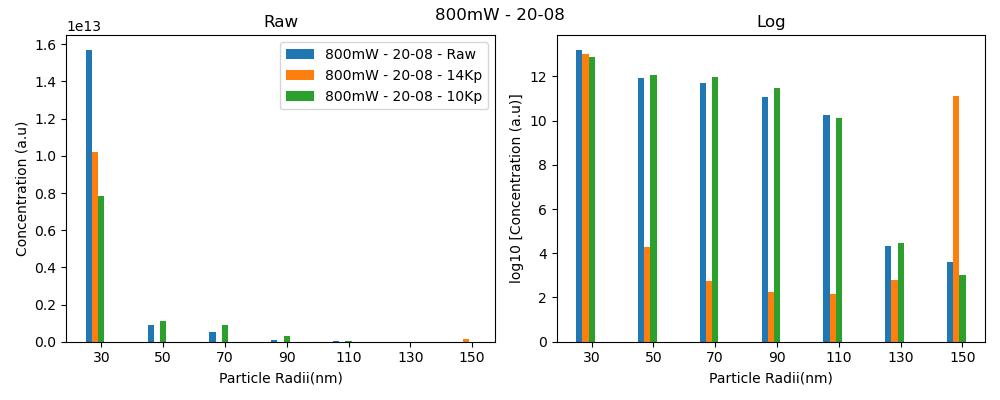

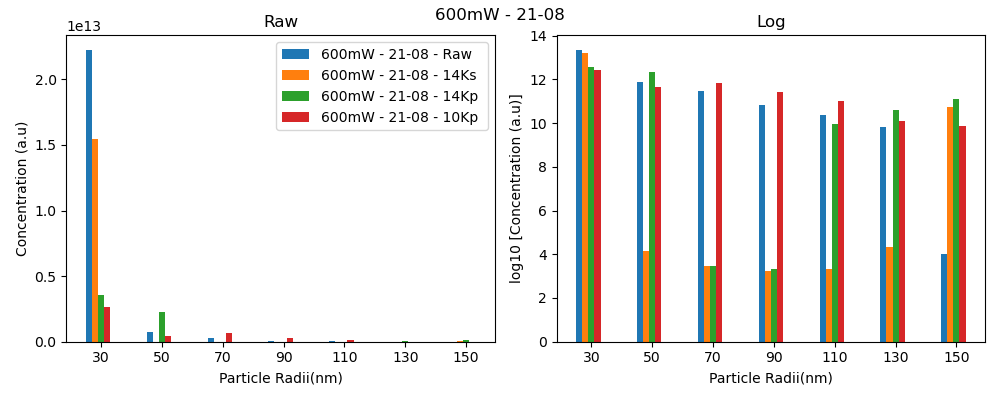

In [23]:
column_groups = group_columns(con_df_bin.columns, 'Radii (nm)')


for column_group in column_groups:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    
    y_columns = [col for col in column_group if 'radii' not in col.lower()] # select just the norm fields

    y_columns = reorder_list(y_columns)
    
    for y_col, index in zip(y_columns, range(len(y_columns))):
        ax[0].bar(con_df_bin['Radii (nm)'] - 2*(2 - index), (con_df_bin[y_col]), label = y_col, width=2)
        ax[1].bar(con_df_bin['Radii (nm)'] - 2*(2 - index), np.log10(con_df_bin[y_col]), label = y_col, width=2)
        
        
    ax[0].legend()
    ax[0].set_ylabel("Concentration (a.u)")
    ax[1].set_ylabel("log10 [Concentration (a.u)]")

    ax[0].set_xlabel("Particle Radii(nm)")
    ax[1].set_xlabel("Particle Radii(nm)")

    ax[0].set_title("Raw")
    ax[1].set_title("Log")

    ax[0].set_xticks(con_df_bin['Radii (nm)'])
    ax[1].set_xticks(con_df_bin['Radii (nm)'])

    fig.tight_layout()

    # changes '1.4W - 21-08 -*' into '1.4W - 21-08'
    name = ' - '.join(column_group[1].split(' - ')[:2])
    fig.suptitle(name)
        
    path = plot_basepath + "concentrations/" + name + ' concentrations - complete.png'
    # fig.savefig(path, dpi=300)

### The Mass Persentage of the samples

Do the small particles dominate the mass percentage of the produced particles?

This will help give inference to where majority of the mass is within the particle.
--> all for use to state what timefrmae the particles are produced from glover’s results

Normalised data using L1 mode.


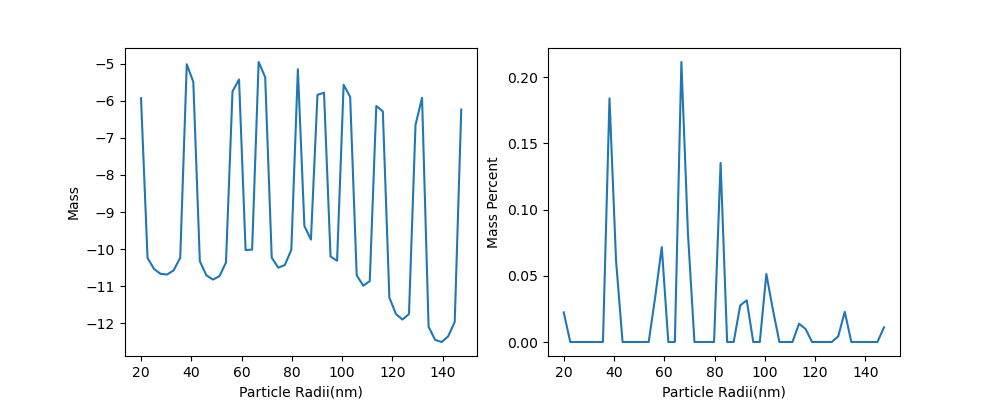

In [158]:
def get_mass_precent(data_in : pd.DataFrame, norm_mode = 'L1'):
    
    data = data_in.copy()

    volume = (4/3) * np.pi * np.pow((data_in['Radii (nm)'] * 1e-9), 3) # volume in SI --> m^3

    silicon_density = 2330 #kg/m^3

    mass = volume * silicon_density

    # Drops the Radius column -> not needed for the analysis
    data = data.drop('Radii (nm)', axis = 1)

    # Removes the Bins field if present
    if 'Bins' in data.columns:
        data = data.drop('Bins', axis = 1)
    

    for y_col in data.columns:
        data[y_col] = data[y_col] * mass


    data['Radii (nm)'] = data_in['Radii (nm)']

    # Will normalise the data if a mode is proided
    if norm_mode is not None:
        data = normalize_data(data, ['Radii (nm)'], mode = norm_mode)

        # Only return the norm values
        data = data.filter(like='_norm')

    # Remove the _norm* from each of the column names
    data.columns = data.columns.str.replace(r'_.*', '', regex=True)


    # Add the radii column back to the df
    data['Radii (nm)'] = data_in['Radii (nm)']

    return data

    

mass = get_mass_precent(con_df, norm_mode=None)
mass1 = get_mass_precent(con_df, norm_mode='L1')

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

ax[0].plot(mass['Radii (nm)'], np.log10(mass['1W - 21-08 - 10Kp']))
ax[1].plot(mass1['Radii (nm)'], (mass1['1W - 21-08 - 10Kp']))

ax[0].set_xlabel("Particle Radii(nm)")
ax[1].set_xlabel("Particle Radii(nm)")


ax[0].set_ylabel("Mass")
ax[1].set_ylabel("Mass Percent")


plt.show()

Normalised data using L1 mode.


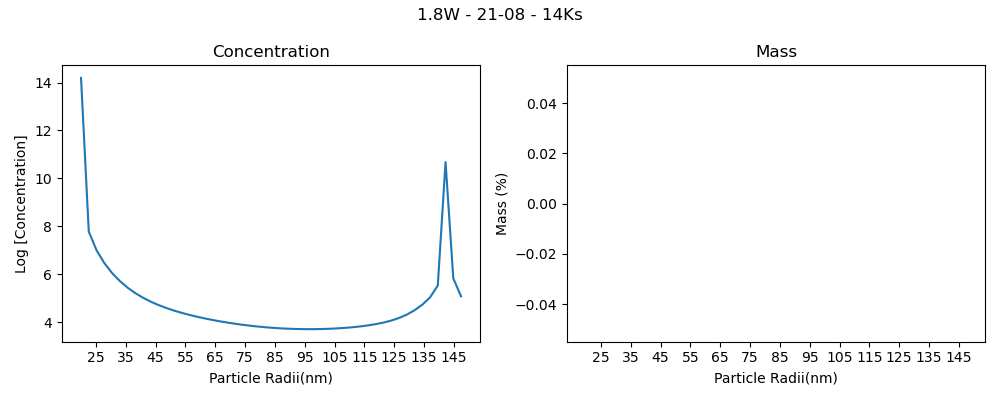

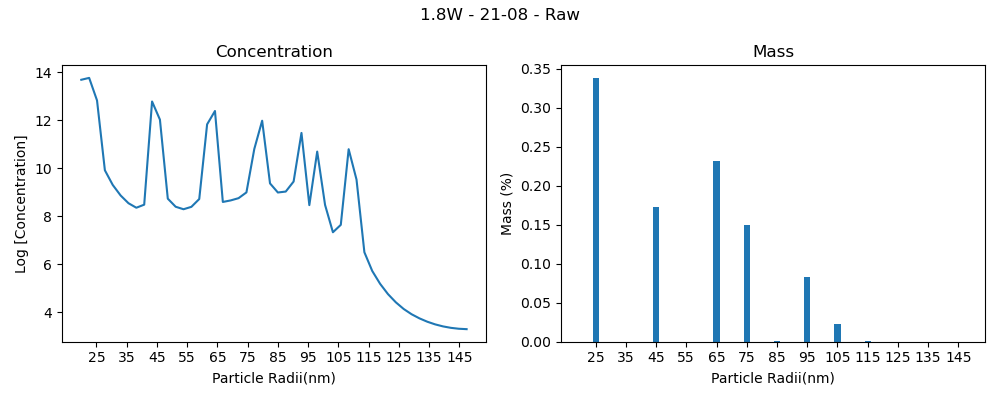

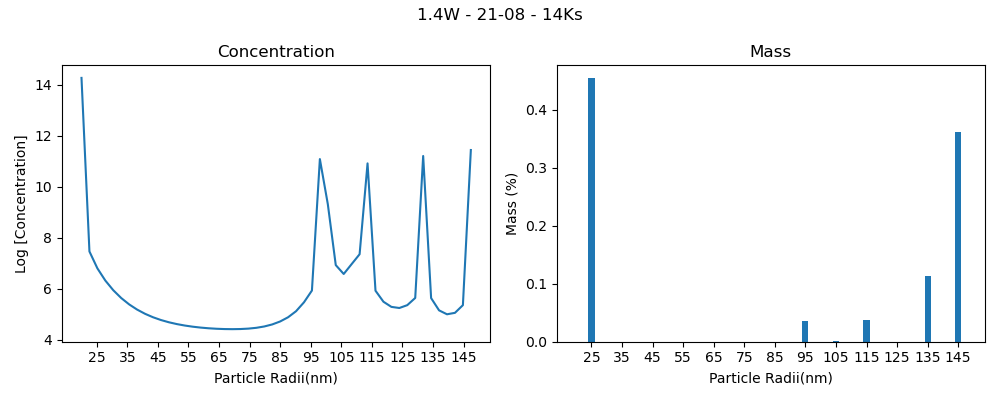

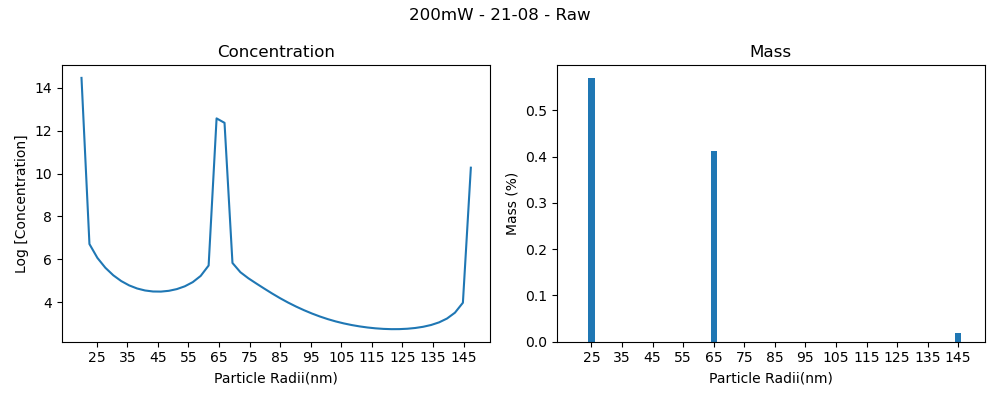

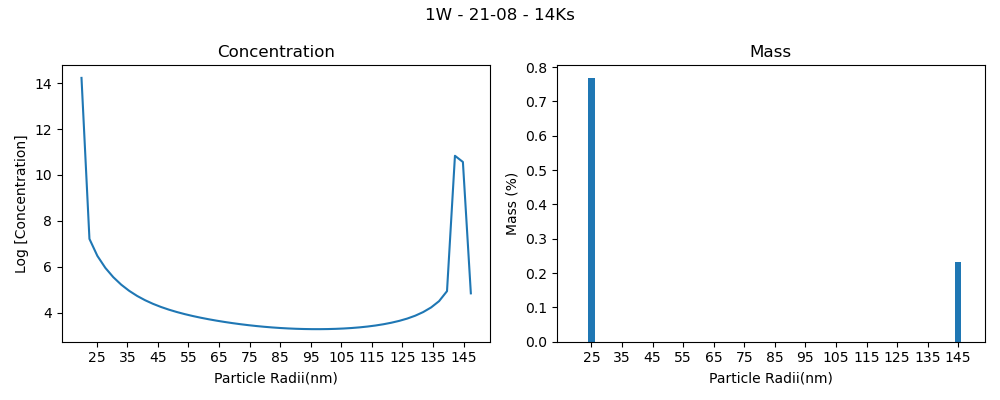

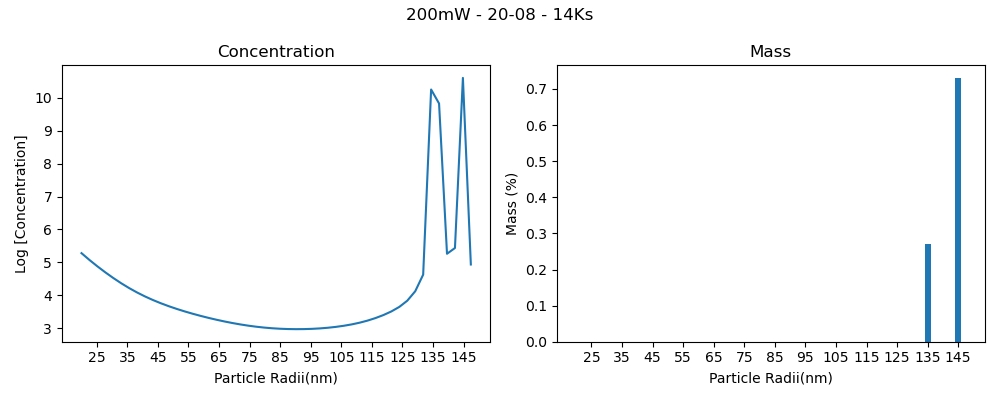

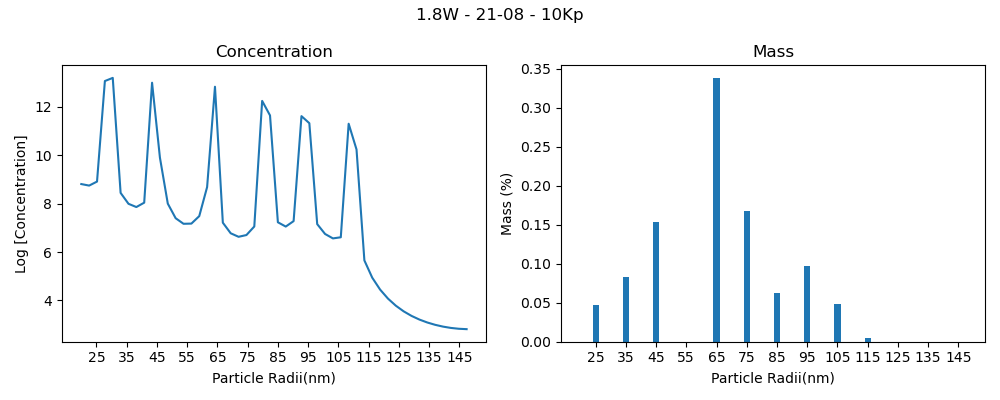

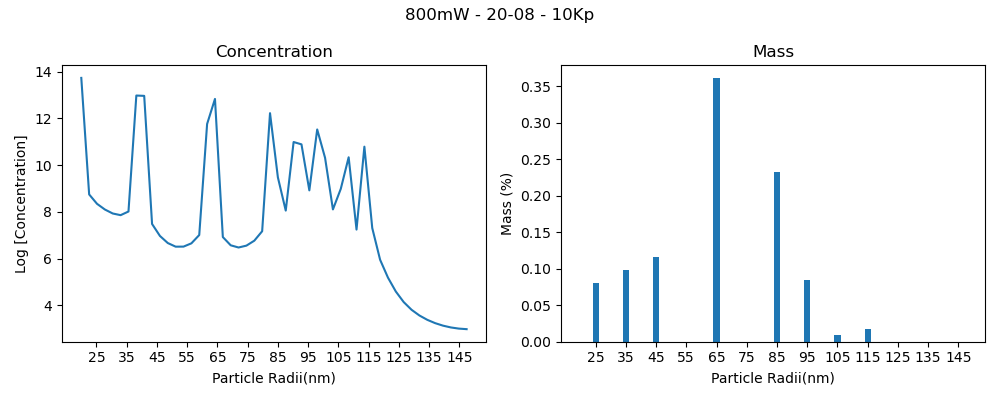

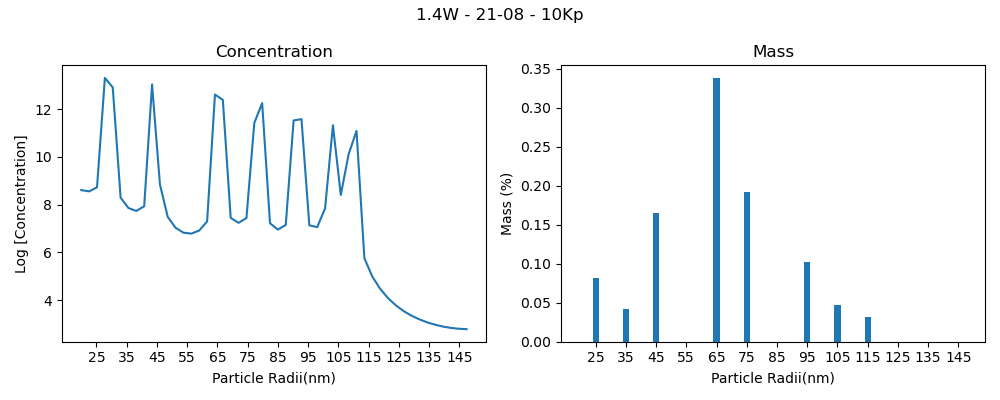

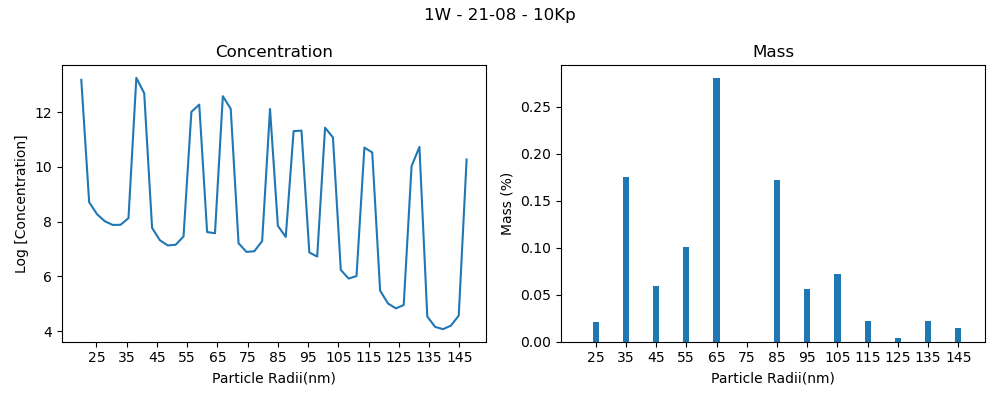

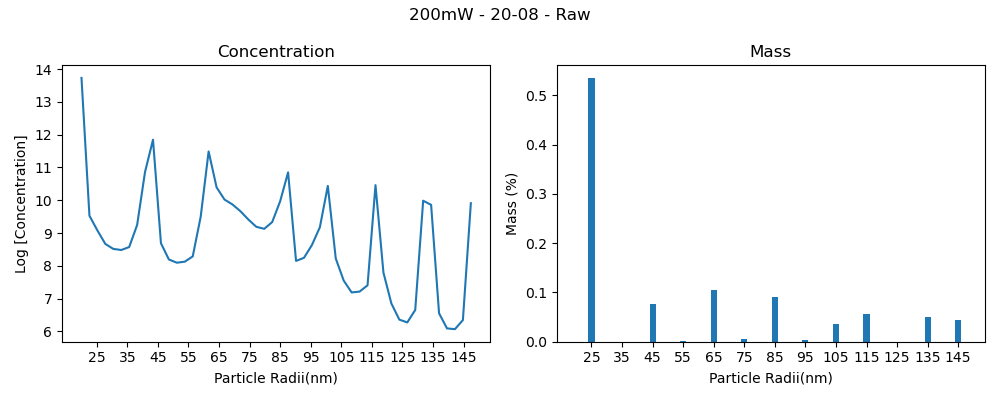

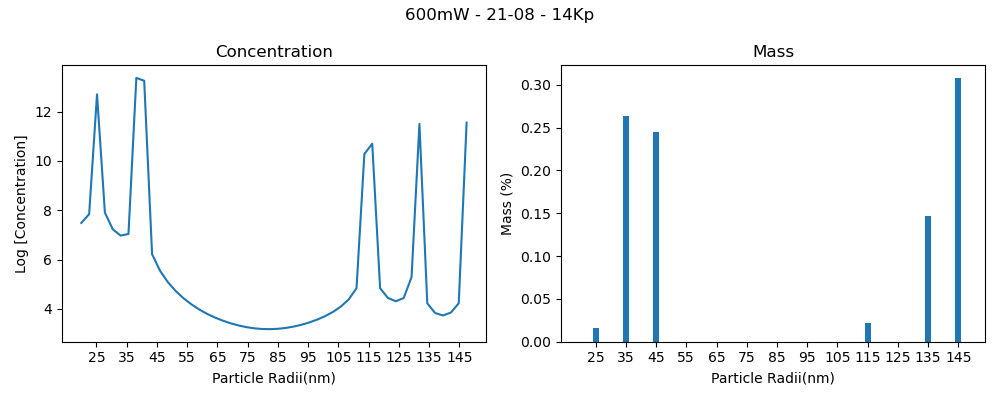

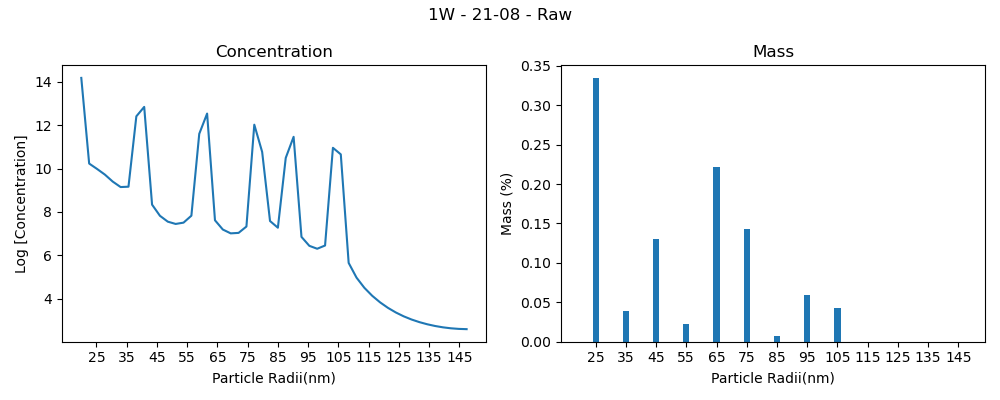

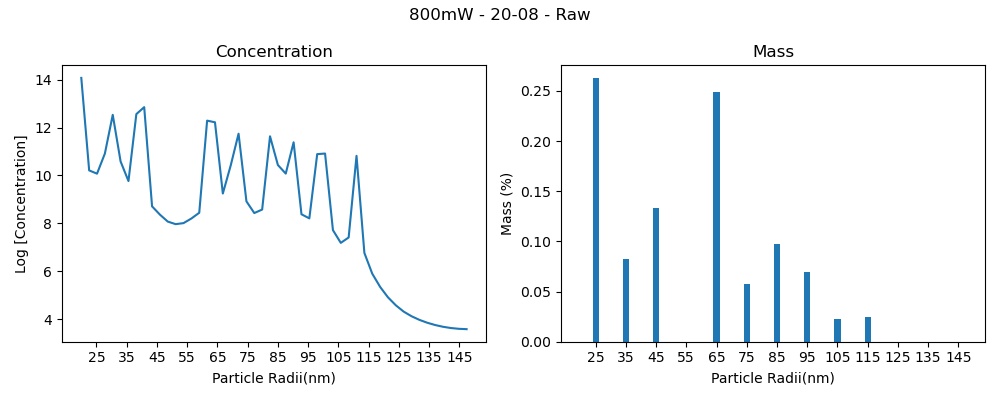

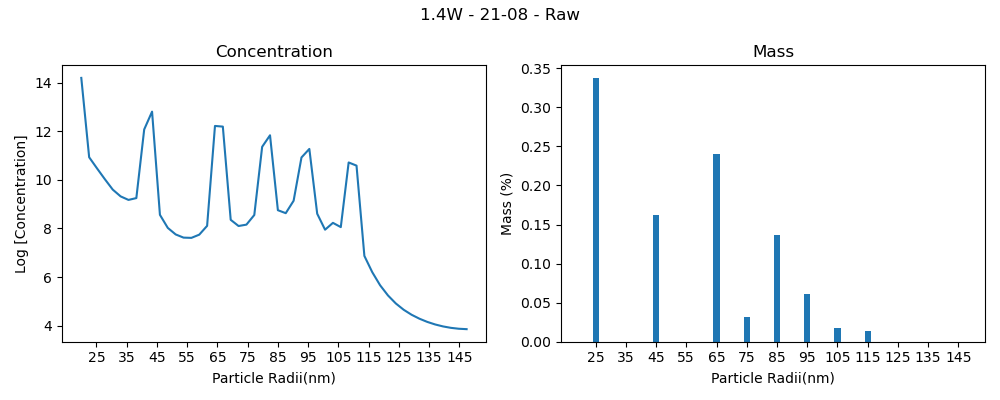

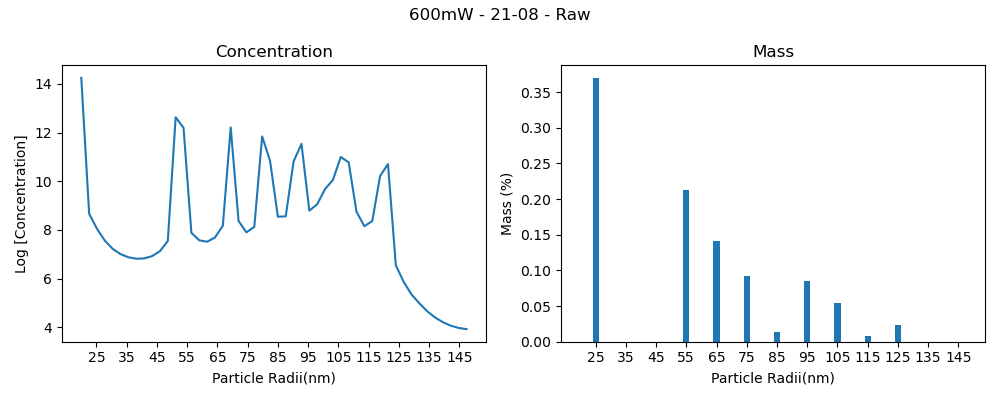

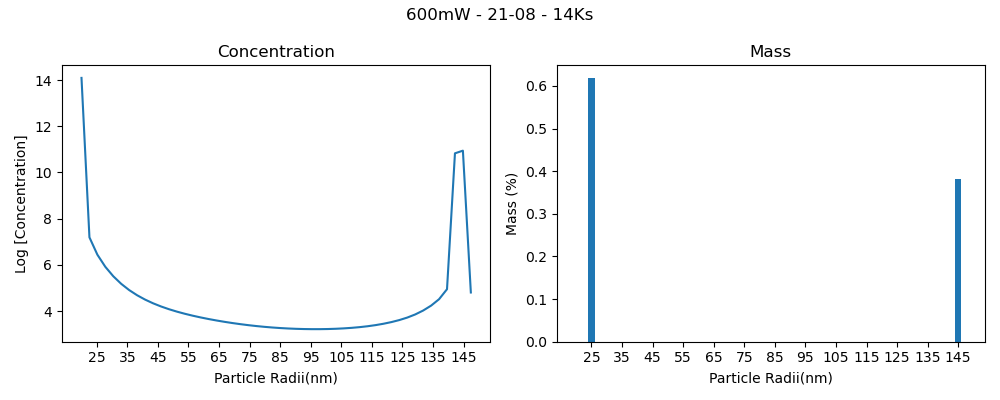

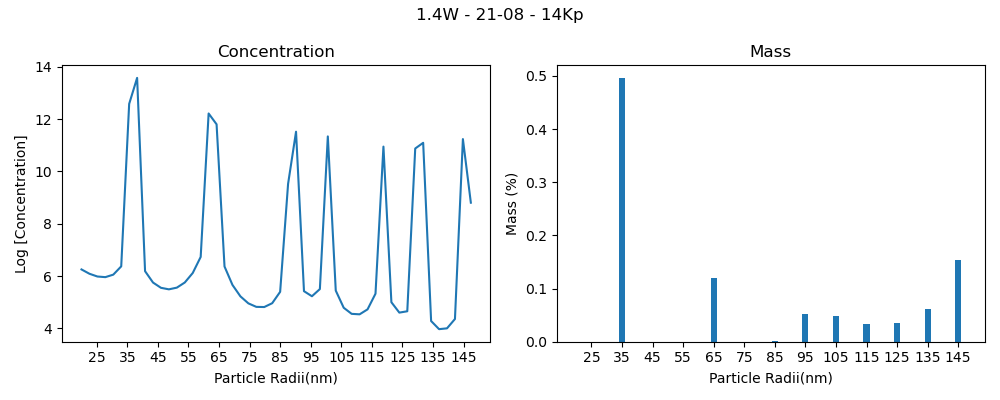

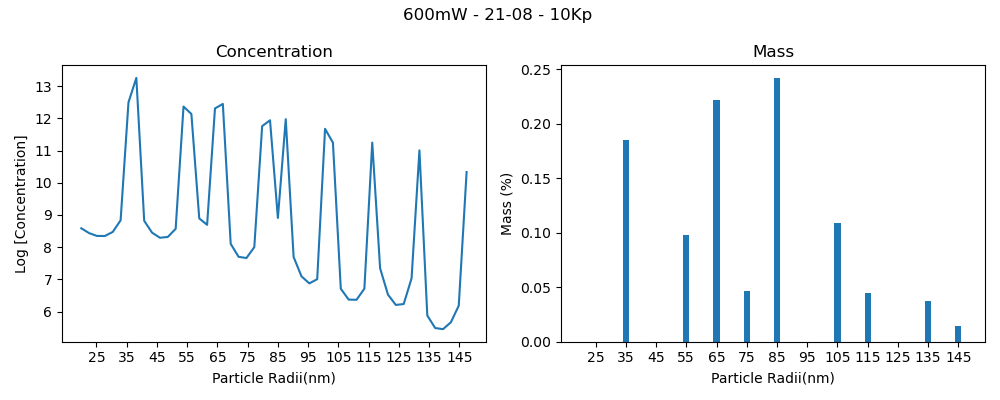

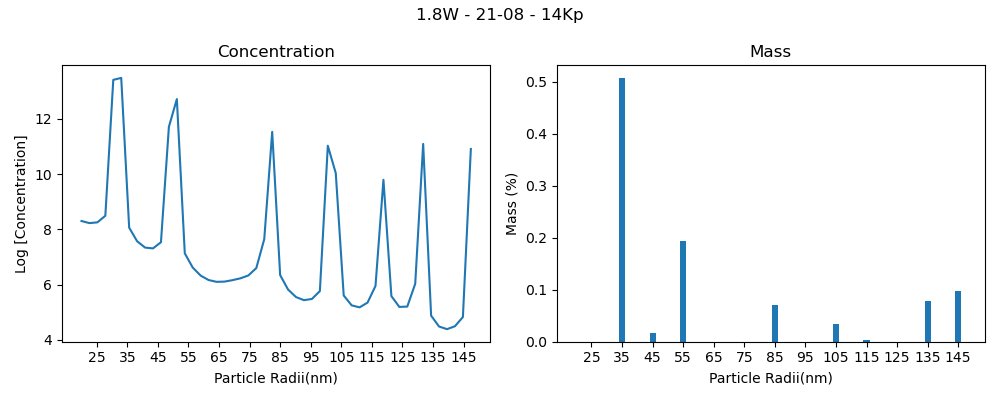

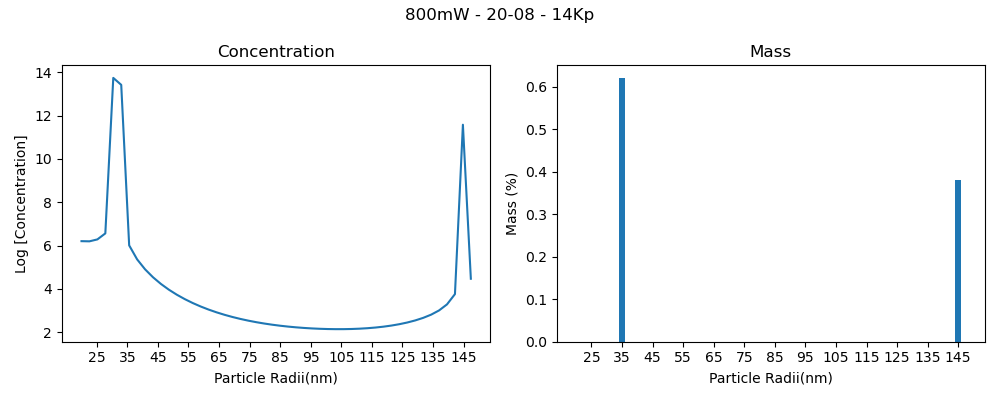

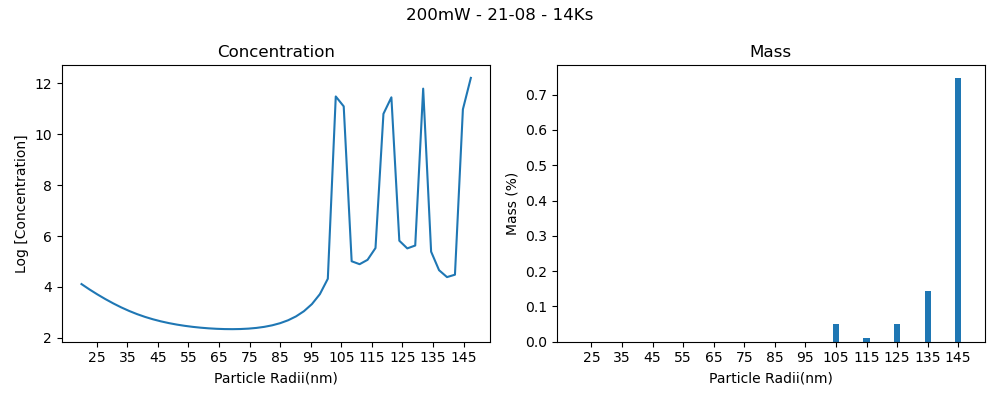

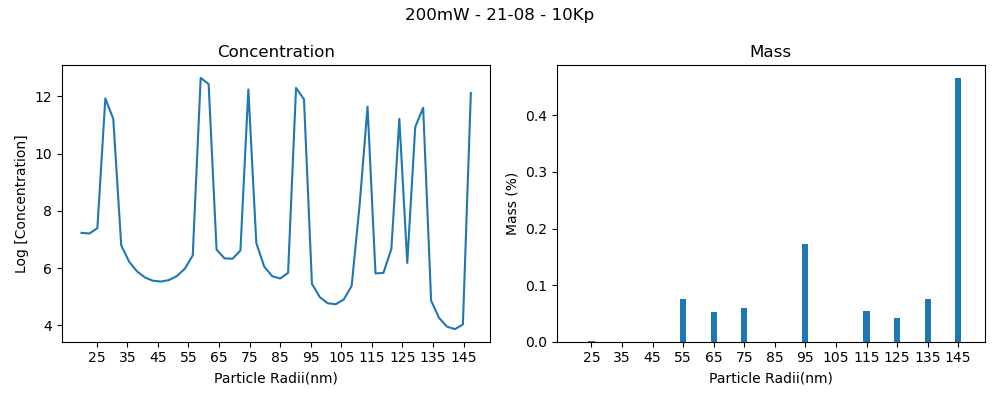

In [161]:
mass_bin = get_df_bins(mass, 10)
mass_bin = normalize_data(mass_bin, ['Radii (nm)'], "L1")

radii_hold = mass_bin['Radii (nm)'].copy()

# Only return the norm values
mass_bin = mass_bin.filter(like='_norm')

# Remove the _norm* from each of the column names
mass_bin.columns = mass_bin.columns.str.replace(r'_.*', '', regex=True)

mass_bin['Radii (nm)'] = radii_hold

y_columns = [col for col in mass_bin if 'radii' not in col.lower()] # select just the norm fields

for y_col, index in zip(y_columns, range(len(y_columns))):
    fig, ax = plt.subplots(1,2, figsize=(10, 4), sharex=True)

    fig.suptitle(y_col)

    ax[0].plot(con_df['Radii (nm)'], np.log10(con_df[y_col]))
    ax[1].bar(mass_bin['Radii (nm)'], (mass_bin[y_col]), width=2)
        
    ax[0].set_xlabel("Particle Radii(nm)")
    ax[1].set_xlabel("Particle Radii(nm)")

    ax[0].set_ylabel("Log [Concentration]")
    ax[1].set_ylabel("Mass (%)")

    ax[0].set_title("Concentration")
    ax[1].set_title("Mass")

    ax[1].set_xticks(mass_bin['Radii (nm)'])

    fig.tight_layout()

    # changes '1.4W - 21-08 -*' into '1.4W - 21-08'
    name = ' - '.join(y_col[1].split(' - ')[:2])
    
    path = plot_basepath + "mass_percentage/" + y_col + '.png'
    fig.savefig(path, dpi=300)


In [162]:
save_dataframe(mass_bin, plot_basepath + "mass_percentage.xlsx")
# mass_bin.columns

DataFrame successfully saved to /Users/william/Library/CloudStorage/OneDrive-SwinburneUniversity/Classes/2024 hons/Silicon NP and Optical Forces - Project/Centrifugation Data/2024/20240821/Plots/mass_percentage.xlsx


True